In [10]:
import os 
import sys
# fix this later!
# sys.path.insert(0, '/home/sumry2023_cqx3/hypergraph_scattering')
from hypgs.models.hyper_scattering_net import HSN

import dhg 
import torch 
import torch.optim as optim

from typing import Tuple, Optional 
from dhg.random import set_seed
from dhg import Graph
from dhg.models import GCN
from dhg.metrics import GraphVertexClassificationEvaluator as Evaluator
import time
import torch.nn.functional as F
import torch.nn as nn
import random
from tqdm import trange
import matplotlib.pyplot as plt

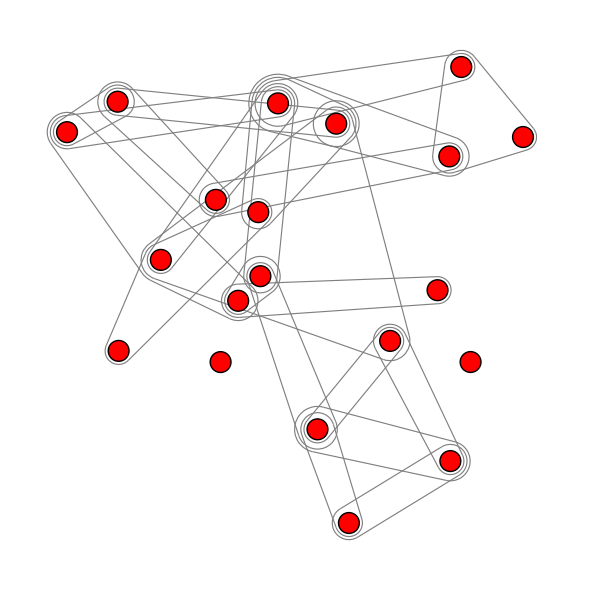

In [11]:
num_v = 20
num_e = 22
hg = dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first')
hg.draw()

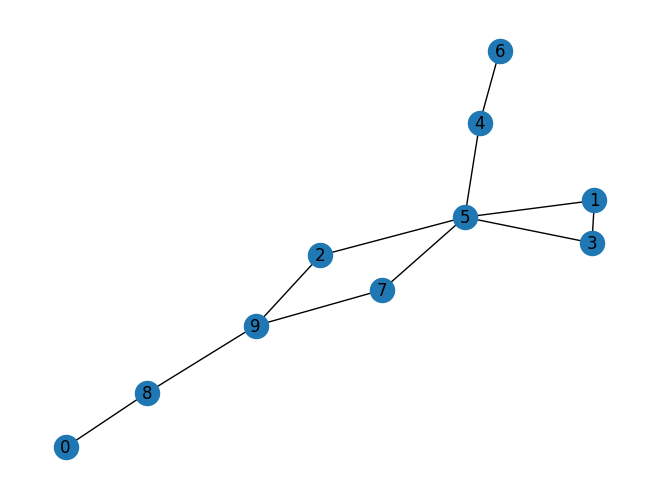

In [12]:
# visualize converting an ER graph into a hypergraph with the desired features
import torch
from torch_geometric.utils import from_networkx

import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph using NetworkX
G = nx.fast_gnp_random_graph(10, 0.3)  # Generate a random graph with 10 nodes and edge probability 0.3

# Visualize the generated graph (optional)
nx.draw(G, with_labels=True)
plt.show()

# Convert NetworkX graph to PyTorch Geometric data object
data = from_networkx(G)


In [13]:
data.edge_index.shape

torch.Size([2, 22])

In [14]:
data

Data(edge_index=[2, 22], num_nodes=10)

In [18]:
from torch_geometric.utils import to_undirected

# Assuming data.edge_index is your edge index tensor

# Convert edge_index to an undirected graph to ensure no duplicates
edge_index_undirected = to_undirected(data.edge_index)

# Transpose the edge index to get unique edges
unique_edges = edge_index_undirected.t().tolist()

# Convert to tuples of integers
edges_as_tuples = [(int(edge[0]), int(edge[1])) for edge in unique_edges]

print(edges_as_tuples)

[(0, 8), (1, 3), (1, 5), (2, 5), (2, 9), (3, 1), (3, 5), (4, 5), (4, 6), (5, 1), (5, 2), (5, 3), (5, 4), (5, 7), (6, 4), (7, 5), (7, 9), (8, 0), (8, 9), (9, 2), (9, 7), (9, 8)]


In [19]:
hg = dhg.Hypergraph(data.num_nodes, edges_as_tuples)

In [56]:
def data_to_hg(data, add_k_hop = 0, min_k_hop_size = 0):
    edge_index_undirected = to_undirected(data.edge_index)
    unique_edges = edge_index_undirected.t().tolist()

    edges_as_tuples = [(int(edge[0]), int(edge[1])) for edge in unique_edges]
    if add_k_hop:
        g = dhg.Graph(data.num_nodes, edges_as_tuples)
        hg_k_hop = dhg.Hypergraph.from_graph_kHop(g, k = add_k_hop)
        hyperedges = hg_k_hop.e 
        if min_k_hop_size > 0:
            hyperedges_filtered = [edge for edge in hyperedges[0] if len(edge) > min_k_hop_size]
            edges_as_tuples = edges_as_tuples + hyperedges_filtered
        else:
            edges_as_tuples = edges_as_tuples + hyperedges[0]
    hg = dhg.Hypergraph(data.num_nodes, edges_as_tuples)
    return hg

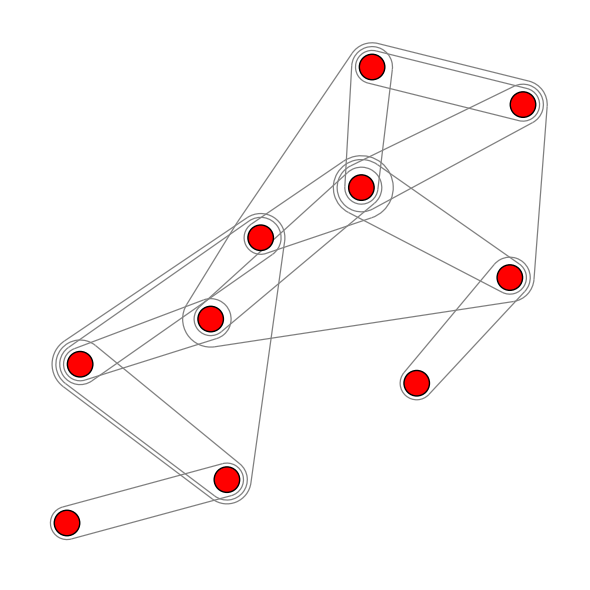

In [59]:
hg = data_to_hg(data, add_k_hop=1, min_k_hop_size = 3)
hg.draw()

In [51]:
!nvidia-smi

Thu Nov 16 13:48:01 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 5000                On  | 00000000:3B:00.0 Off |                  Off |
| 33%   20C    P8               7W / 230W |      3MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

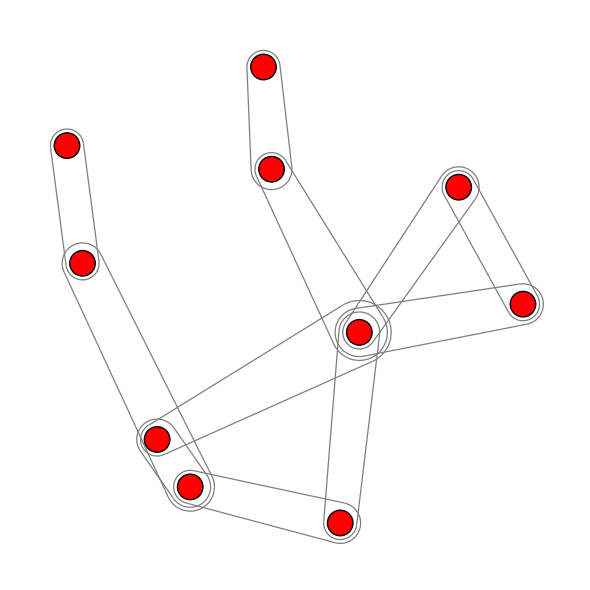

In [20]:
hg.draw()

In [ ]:
hg = dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first')


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
num_vertices = 15
hg = dhg.random.uniform_hypergraph_Gnp(3,num_vertices, .4).to(device)
signal_features = 2
X = torch.rand(num_vertices, signal_features).to(device)
Y = torch.zeros((hg.num_e, signal_features)).to(device)

hidden_channels = 16
out_channels = 1
net = HSN(signal_features, hidden_channels, 1).to(device)
#import pdb; pdb.set_trace()

node_pred, edge_pred = net(hg, X, Y)
node_pred.shape

torch.Size([15, 1])

In [6]:
num_v = 15; num_e = 30
hypergraph_dataset = [dhg.random.hypergraph_Gnm(num_v, num_e, method = 'low_order_first') for _ in range(50)]


In [10]:
net = HSN(signal_features, hidden_channels, 1).to(device)
random.shuffle(hypergraph_dataset)
for hg in hypergraph_dataset:
    hg = hg.to(device)
    signal_features = 2
    X = torch.rand(num_v, signal_features).to(device)
    Y = torch.zeros((hg.num_e, signal_features)).to(device)
    node_pred, edge_pred = net(hg, X, Y)